# Data Loading and Quality Control

This notebook performs initial data loading and exploratory data analysis (EDA) on the American Gut Project (AGP) dataset.

## Objectives:
- Load feature table, metadata, and taxonomy data
- Inspect data structure and dimensions
- Perform quality control checks
- Generate summary statistics
- Visualize key distributions

## 1. Import Libraries

In [72]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Polars display options
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(100)

polars.config.Config

## 2. Load Data Files

We'll load the three core datasets from the American Gut Project: participant metadata, bacterial abundance counts (feature table), and taxonomic classifications. Each dataset will be explored individually to understand structure, quality, and distributions before analyzing relationships between coffee consumption and microbiome composition.

In [73]:
# Define data paths
data_dir = Path('../data/raw')
feature_table_path = data_dir / 'feature-table.tsv'
metadata_path = data_dir / 'metadata.tsv'
taxonomy_path = data_dir / 'taxonomy.tsv'

# Load data with Polars
print("Loading feature table...")
feature_table = pl.read_csv(feature_table_path, separator='\t')

print("Loading metadata...")
metadata = pl.read_csv(metadata_path, separator='\t')

print("Loading taxonomy...")
taxonomy = pl.read_csv(taxonomy_path, separator='\t')

print("\n✓ All data loaded successfully!")
print(f"\nMetadata shape: {metadata.shape}")
print(f"Feature table shape: {feature_table.shape}")
print(f"Taxonomy shape: {taxonomy.shape}")

Loading feature table...
Loading metadata...
Loading taxonomy...

✓ All data loaded successfully!

Metadata shape: (1000, 9)
Feature table shape: (500, 1001)
Taxonomy shape: (500, 2)


## Dataset Structure Overview

The data dimensions above reflect our subset downloaded by the `download_agp_sample.py` script:

**Metadata (1000 × 8)**: 1,000 participant samples with 8 variables including demographics, diet, and lifestyle factors

**Feature Table (500 × 1001)**: 
- 500 rows = OTUs (Operational Taxonomic Units - unique bacterial sequences)
- 1,001 columns = 1 OTU identifier + 1,000 sample abundance counts
- Each cell contains read counts representing bacterial abundance in that sample

**Taxonomy (500 × 2)**: 
- 500 rows corresponding to the same OTUs in the feature table
- 2 columns: OTU identifier + taxonomic classification string
- The taxonomy string contains hierarchical classification (Kingdom→Species) that we'll parse into separate rank columns

This structure follows standard microbiome data format where samples are columns, bacterial features are rows, and abundance values fill the matrix.

## 3. Metadata Exploratory Data Analysis

In [74]:
# Display basic metadata info
print("METADATA OVERVIEW")
print("=" * 70)
print(f"\nShape: {metadata.shape[0]} samples × {metadata.shape[1]} columns")
print(f"\nColumn names and types:")
print(metadata.schema)
print(f"\nFirst few rows:")
metadata.head()

METADATA OVERVIEW

Shape: 1000 samples × 9 columns

Column names and types:
Schema([('#SampleID', String), ('age', Int64), ('gender', String), ('country', String), ('sample_type', String), ('diet_type', String), ('coffee_consumption', String), ('antibiotics_past_year', String), ('bmi', Int64)])

First few rows:


#SampleID,age,gender,country,sample_type,diet_type,coffee_consumption,antibiotics_past_year,bmi
str,i64,str,str,str,str,str,str,i64
"""Sample_00000""",56,"""male""","""UK""","""Stool""","""Vegan""","""none""","""Yes""",30
"""Sample_00001""",69,"""male""","""USA""","""Stool""","""Vegan""","""occasional""","""Yes""",27
"""Sample_00002""",46,"""female""","""UK""","""Stool""","""Omnivore""","""occasional""","""No""",24
"""Sample_00003""",32,"""male""","""USA""","""Stool""","""Omnivore""","""occasional""","""No""",31
"""Sample_00004""",60,"""male""","""UK""","""Stool""","""Vegetarian""","""daily""","""Yes""",28


### 3.1 Individual Variable Distributions

Let's start with basic EDA to understand the demographics of our study population. We'll examine the distributions of continuous variables (age, BMI) and categorical variables (gender, country, diet type, coffee consumption, and antibiotic use) to identify any potential confounders or data quality issues.

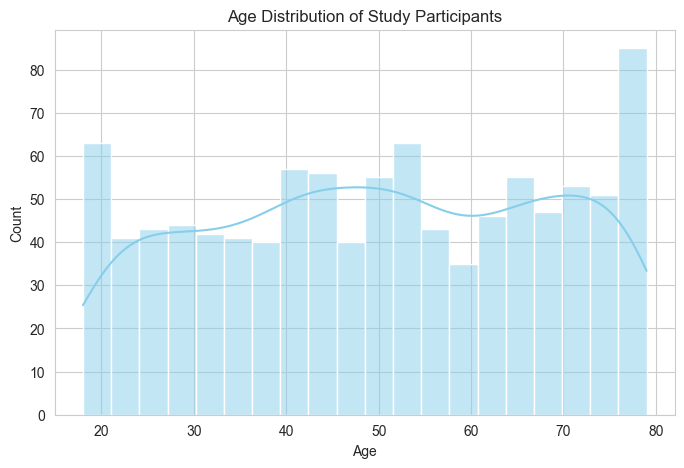

In [75]:
# Display distribution of age
plt.figure(figsize=(8, 5))
sns.histplot(metadata['age'].to_numpy(), bins=20, kde=True, color='skyblue')
plt.title('Age Distribution of Study Participants')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

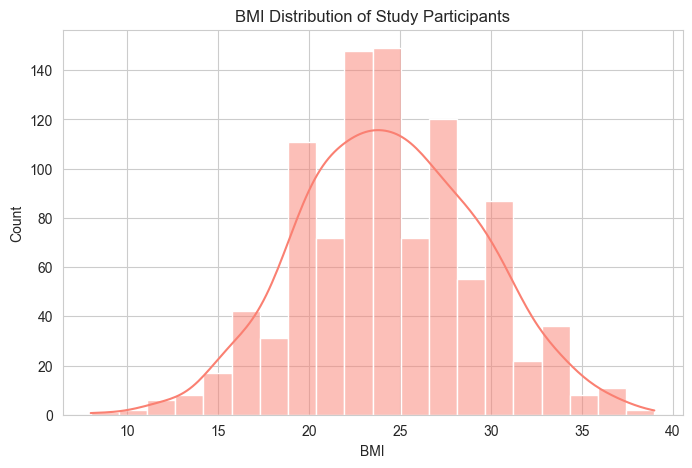

In [76]:
# display distribution of BMI
plt.figure(figsize=(8,5))
sns.histplot(metadata['bmi'].to_numpy(), bins=20, kde=True, color='salmon')
plt.title('BMI Distribution of Study Participants')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

Before creating visualizations, let's first examine the unique values in each categorical variable to understand the data categories and ensure data quality.

In [77]:
# display unique values in categorical columns
categorical_cols = ['gender', 'country', 'sample_type', 'diet_type', 'coffee_consumption', 'antibiotics_past_year']
for col in categorical_cols:
    unique_values = metadata[col].unique().to_list()
    print(f"Unique values in '{col}': {unique_values}")

Unique values in 'gender': ['male', 'female']
Unique values in 'country': ['UK', 'Australia', 'USA', 'Canada']
Unique values in 'sample_type': ['Stool']
Unique values in 'diet_type': ['Vegetarian', 'Vegan', 'Omnivore']
Unique values in 'coffee_consumption': ['occasional', 'daily', 'none']
Unique values in 'antibiotics_past_year': ['No', 'Yes']


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_48837/2846669847.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts[col].to_list(), y=counts['count'].to_list(),
/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_48837/2846669847.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts[col].to_list(), y=counts['count'].to_list(),
/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_48837/2846669847.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts[col].to_list(), y=counts['count'].to_list(),
/

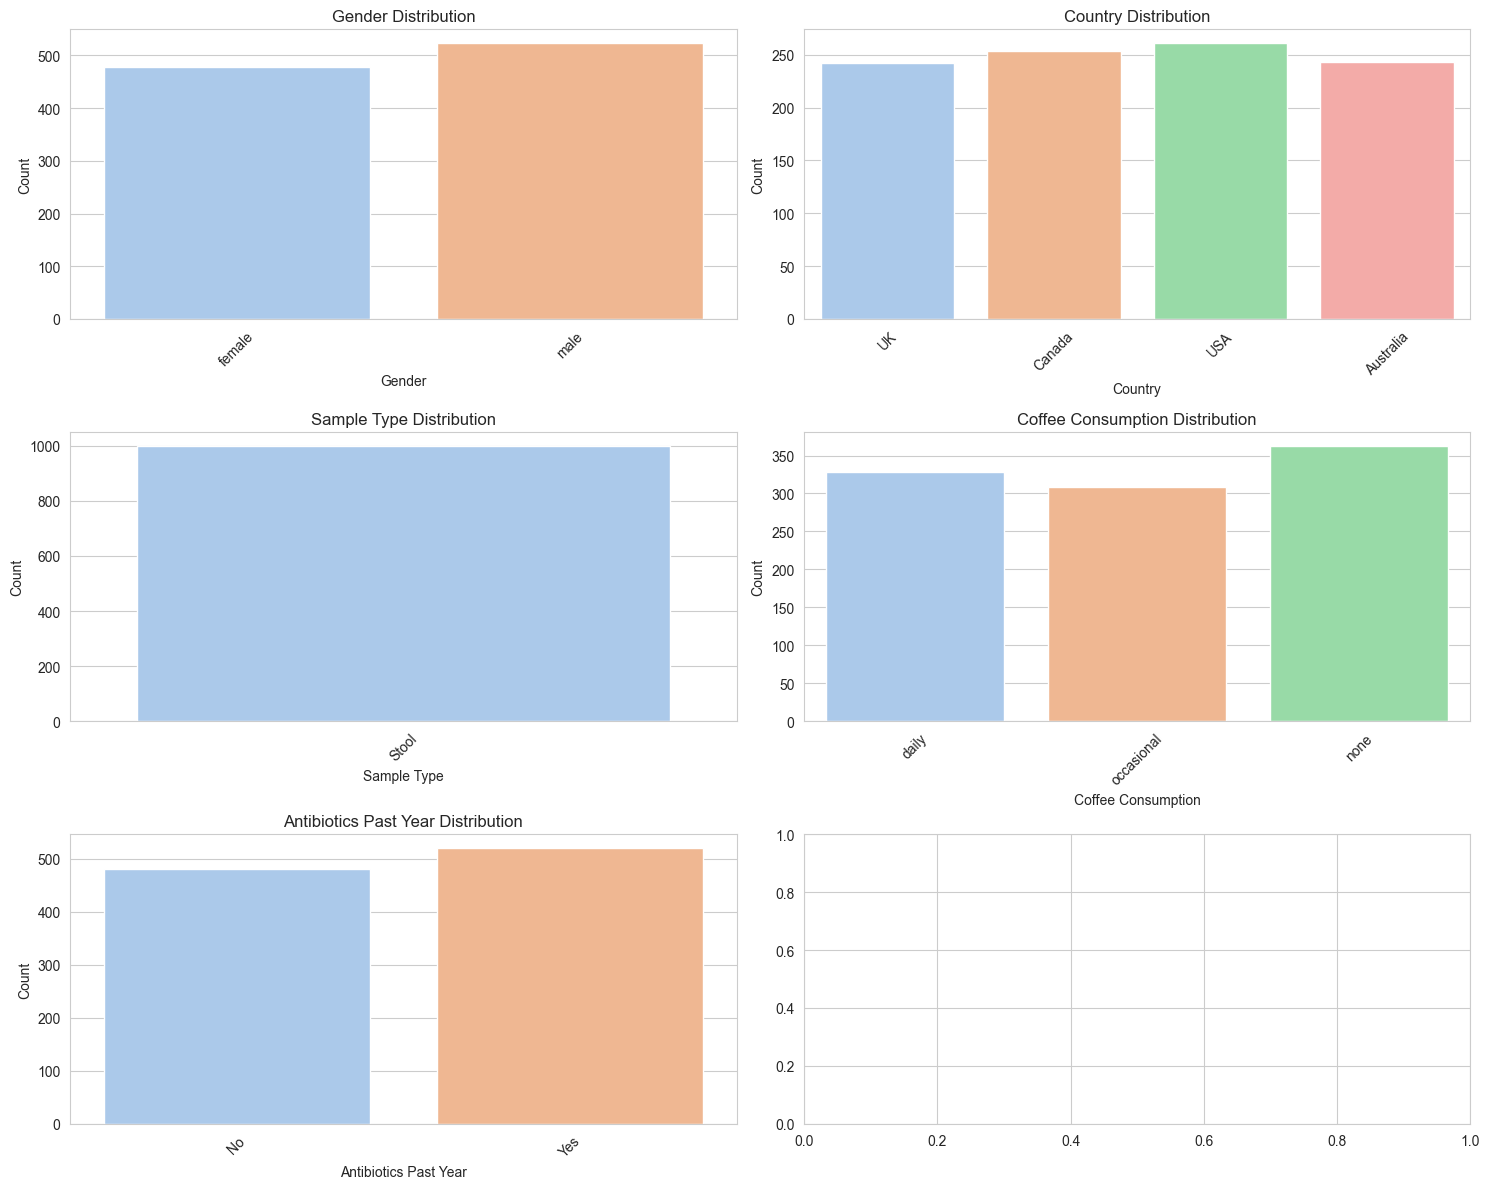

In [100]:
# Create subplots for categorical variables in a 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    # plot distribution
    counts = metadata[col].value_counts()
    sns.barplot(x=counts[col].to_list(), y=counts['count'].to_list(), 
               palette='pastel', ax=axes[i])
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution')
    axes[i].set_xlabel(col.replace("_", " ").title())
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Diet Type Breakdown

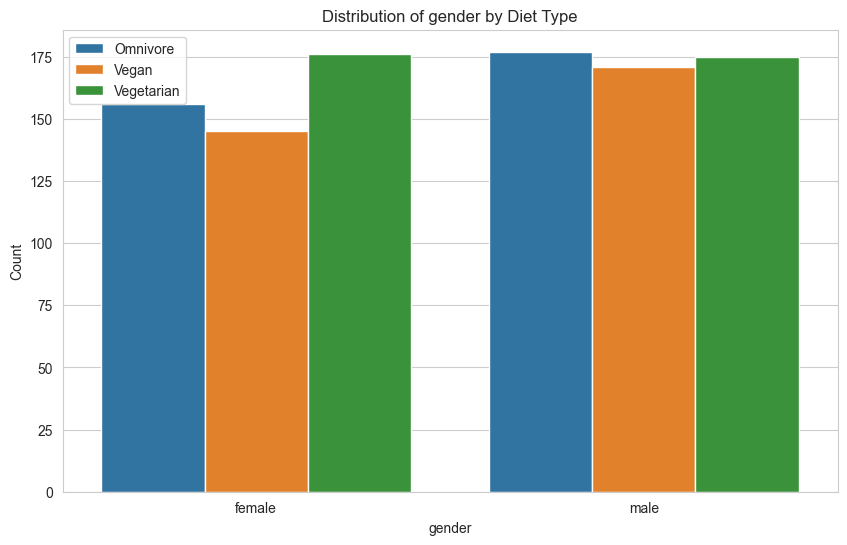

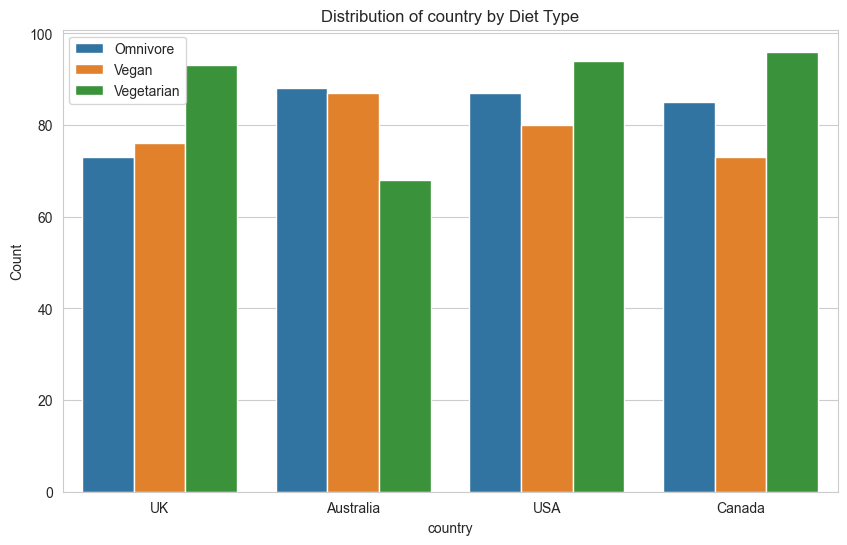

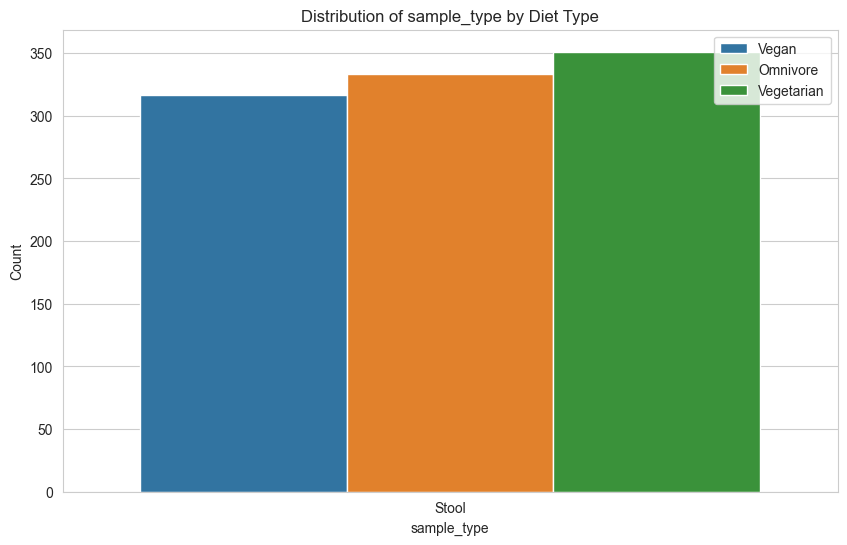

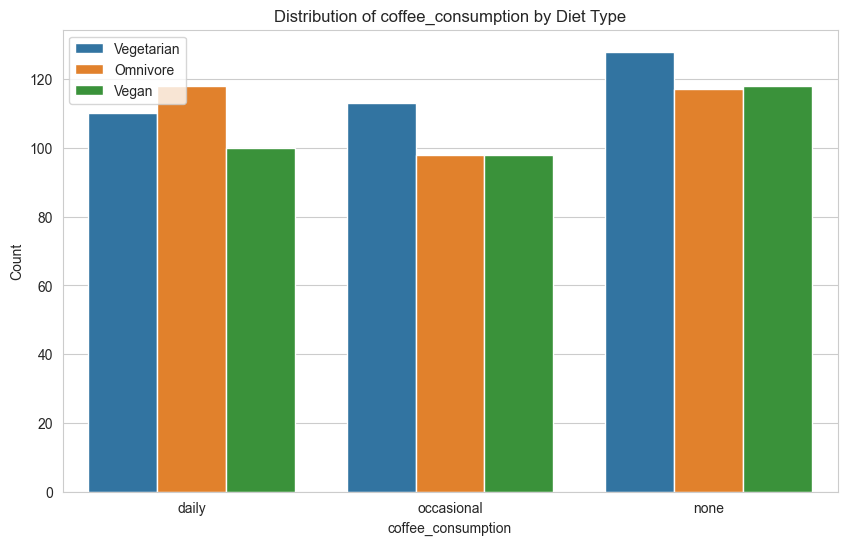

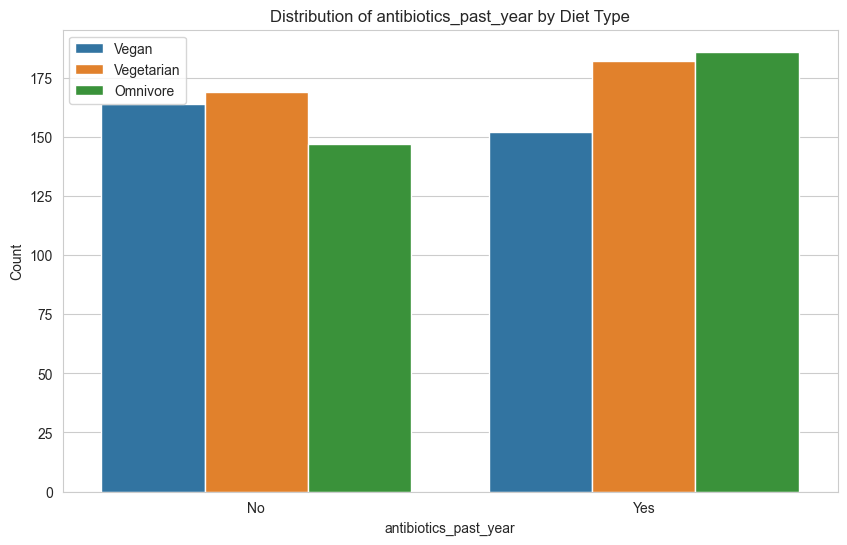

In [83]:
# loop through all categorical columns except diet_type
categorical_cols = ['gender', 'country', 'sample_type', 'coffee_consumption', 'antibiotics_past_year']
diet_types = metadata['diet_type'].unique().to_list()

for col in categorical_cols:
    # count occurrences of each category within each diet type
    category_counts = metadata.group_by([col, 'diet_type']).len()
    # bar plot showing distribution of the categorical column within each diet type
    plt.figure(figsize=(10,6))
    sns.barplot(x=category_counts[col].to_list(), y=category_counts['len'].to_list(), hue=category_counts['diet_type'].to_list())
    plt.title(f'Distribution of {col} by Diet Type')
    plt.xlabel(col)
    plt.ylabel('Count')


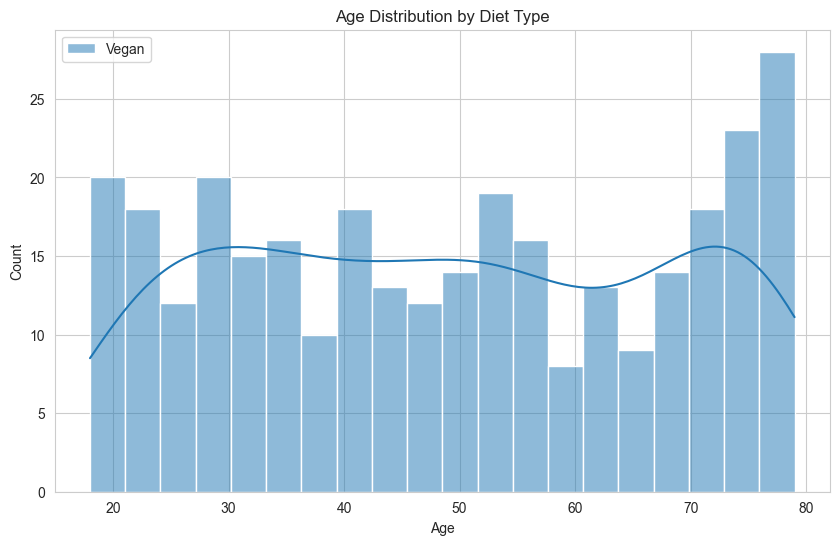

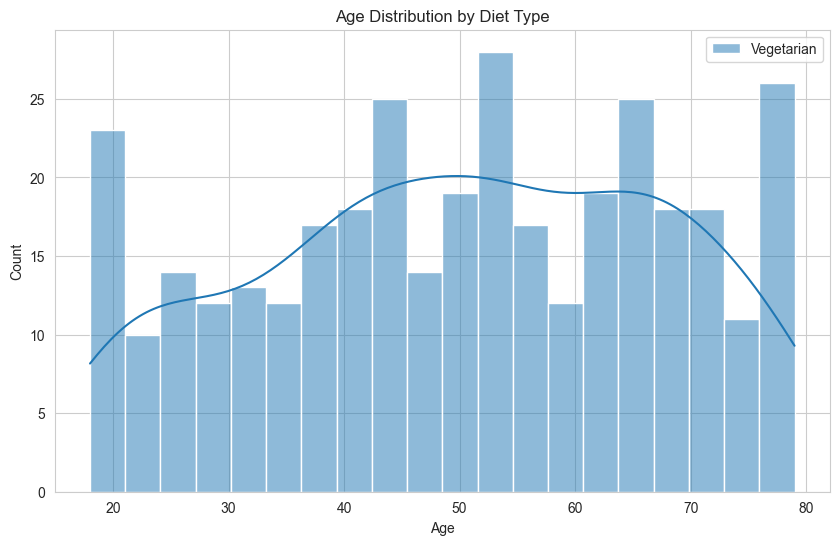

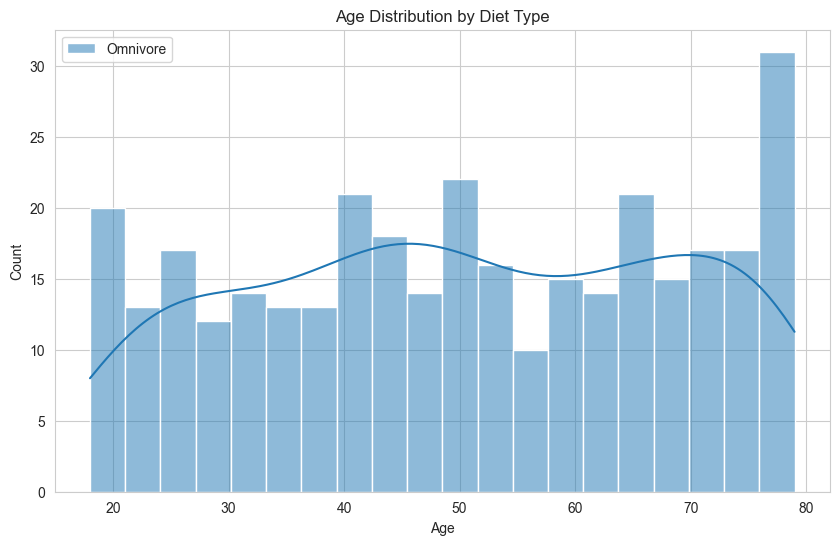

In [84]:
# display a histogram of age distribution per diet type
plt.figure(figsize=(10,6))
for diet in diet_types:
    subset = metadata.filter(pl.col('diet_type') == diet)
    sns.histplot(subset['age'].to_numpy(), bins=20, kde=True, label=diet, alpha=0.5)
    plt.title('Age Distribution by Diet Type')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

In [85]:
# compute average and std of age per diet type
age_stats = metadata.group_by('diet_type').agg([
    pl.col('age').mean().alias('average_age'),
    pl.col('age').std().alias('std_age')
])
print("\nAverage and Standard Deviation of Age per Diet Type:")
print(age_stats)


Average and Standard Deviation of Age per Diet Type:
shape: (3, 3)
┌────────────┬─────────────┬───────────┐
│ diet_type  ┆ average_age ┆ std_age   │
│ ---        ┆ ---         ┆ ---       │
│ str        ┆ f64         ┆ f64       │
╞════════════╪═════════════╪═══════════╡
│ Omnivore   ┆ 50.15015    ┆ 18.262353 │
│ Vegan      ┆ 49.231013   ┆ 18.845246 │
│ Vegetarian ┆ 50.14245    ┆ 17.32223  │
└────────────┴─────────────┴───────────┘


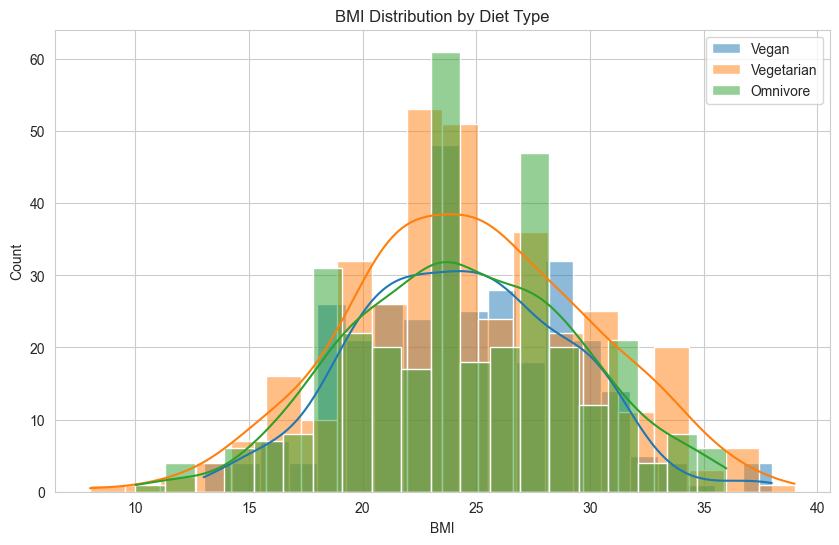

In [86]:
# show distribution of bmi per diet type
plt.figure(figsize=(10,6))
for diet in diet_types:
    subset = metadata.filter(pl.col('diet_type') == diet)
    sns.histplot(subset['bmi'].to_numpy(), bins=20, kde=True, label=diet, alpha=0.5)
plt.title('BMI Distribution by Diet Type')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.legend()
plt.show()

In [87]:
# compute avg, std, median of bmi per diet type
bmi_stats = metadata.group_by('diet_type').agg([
    pl.col('bmi').mean().alias('average_bmi'),
    pl.col('bmi').std().alias('std_bmi'),
    pl.col('bmi').median().alias('median_bmi')
])
print("\nAverage, Standard Deviation, and Median of BMI per Diet Type:")
print(bmi_stats)


Average, Standard Deviation, and Median of BMI per Diet Type:
shape: (3, 4)
┌────────────┬─────────────┬──────────┬────────────┐
│ diet_type  ┆ average_bmi ┆ std_bmi  ┆ median_bmi │
│ ---        ┆ ---         ┆ ---      ┆ ---        │
│ str        ┆ f64         ┆ f64      ┆ f64        │
╞════════════╪═════════════╪══════════╪════════════╡
│ Omnivore   ┆ 24.363363   ┆ 4.974947 ┆ 24.0       │
│ Vegan      ┆ 24.341772   ┆ 4.59022  ┆ 24.0       │
│ Vegetarian ┆ 24.698006   ┆ 5.318429 ┆ 25.0       │
└────────────┴─────────────┴──────────┴────────────┘


## Taxonomy EDA

In [88]:
# display columns of taxonomy table
print("\nTAXONOMY TABLE COLUMNS")
print("=" * 30)
print(taxonomy.columns)



TAXONOMY TABLE COLUMNS
['#OTU ID', 'Taxonomy']


In [89]:
# display head of taxonomy table
print("\nTAXONOMY OVERVIEW")
print("=" * 70)
print(f"\nFirst few rows:")
taxonomy.head()


TAXONOMY OVERVIEW

First few rows:


#OTU ID,Taxonomy
str,str
"""OTU_0000""","""k__Bacteria;p__Bacteroidetes;c__Gammaproteobacteria;o__Bifidobacteriales;f__Enterobacteriaceae;g__Ba…"
"""OTU_0001""","""k__Bacteria;p__Actinobacteria;c__Bacteroidia;o__Clostridiales;f__Lachnospiraceae;g__Escherichia;s__c…"
"""OTU_0002""","""k__Bacteria;p__Firmicutes;c__Bacteroidia;o__Bifidobacteriales;f__Enterobacteriaceae;g__Roseburia;s__…"
"""OTU_0003""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Bifidobacteriales;f__Lachnospiraceae;g__Esch…"
"""OTU_0004""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Clostridiales;f__Bacteroidaceae;g__Roseburia…"


OTU stands for 'operational taxonomic units'. In layman terms, OTUs are clusters of DNA sequences that resemble closely-related bacteria. OTUs are thus a way to measure diversity in a population of bacteria, such as the microbiome. 

Taxonomy refers to a classification system that identifies which microorganisms 

In [90]:
# print size of taxonomy table
print(f"\nTaxonomy table size: {taxonomy.shape[0]} rows × {taxonomy.shape[1]} columns")


Taxonomy table size: 500 rows × 2 columns


In [91]:
# count taxonomy depths
taxonomy_depths = taxonomy['Taxonomy'].str.split(';').list.len()

# add taxonomy depths as a new column
taxonomy = taxonomy.with_columns(pl.Series(name='Taxonomy_Depth', values=taxonomy_depths))

# display new head 
print("\nTAXONOMY WITH DEPTH OVERVIEW")
print("=" * 70)
print(f"\nFirst few rows with Taxonomy Depth:")
taxonomy.head()


TAXONOMY WITH DEPTH OVERVIEW

First few rows with Taxonomy Depth:


#OTU ID,Taxonomy,Taxonomy_Depth
str,str,u32
"""OTU_0000""","""k__Bacteria;p__Bacteroidetes;c__Gammaproteobacteria;o__Bifidobacteriales;f__Enterobacteriaceae;g__Ba…",7
"""OTU_0001""","""k__Bacteria;p__Actinobacteria;c__Bacteroidia;o__Clostridiales;f__Lachnospiraceae;g__Escherichia;s__c…",7
"""OTU_0002""","""k__Bacteria;p__Firmicutes;c__Bacteroidia;o__Bifidobacteriales;f__Enterobacteriaceae;g__Roseburia;s__…",7
"""OTU_0003""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Bifidobacteriales;f__Lachnospiraceae;g__Esch…",7
"""OTU_0004""","""k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Clostridiales;f__Bacteroidaceae;g__Roseburia…",7


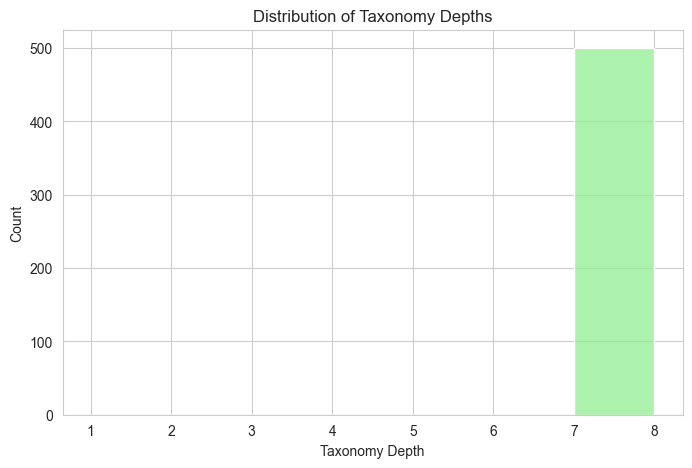

In [92]:
# display distribution of taxonomy depths
plt.figure(figsize=(8,5))
sns.histplot(taxonomy['Taxonomy_Depth'].to_numpy(), bins=range(1, taxonomy['Taxonomy_Depth'].max()+2), kde=False, color='lightgreen')
plt.title('Distribution of Taxonomy Depths')
plt.xlabel('Taxonomy Depth')
plt.ylabel('Count')
plt.show()

# Taxonomy Structure Summary

## Key Finding: All Organisms Have Exactly 7 Taxonomic Ranks

| Rank | Prefix | Example | Explanation |
|------|--------|---------|-------------|
| 1 | Kingdom (k__) | Bacteria | All microbes in AGP are bacteria |
| 2 | Phylum (p__) | Firmicutes | Major bacterial division |
| 3 | Class (c__) | Clostridia | Subdivision of phylum |
| 4 | Order (o__) | Clostridiales | Subdivision of class |
| 5 | Family (f__) | Lachnospiraceae | Subdivision of order |
| 6 | Genus (g__) | Roseburia | Subdivision of family |
| 7 | Species (s__) | faecalis | Most specific classification |

## Why the Distribution Makes Sense

**All rows have exactly 7 tokens because:**
- The American Gut Project uses **16S rRNA gene sequencing**, which follows the standard **Linnaean taxonomy** system
- Every organism is classified at all 7 ranks (kingdom → species) without exception
- This is a fixed biological classification standard, not variable data
- Therefore, when splitting taxonomy by `;`, you always get exactly 7 tokens

In [93]:
# create a column for rank 1 and append to taxonomy table

for rank_no in range(1, 8):
    taxonomy = taxonomy.with_columns(
        pl.col("Taxonomy").str.split(";").list.get(rank_no-1).alias("Rank_{}".format(rank_no))
    )

# remove Taxonomy column
taxonomy = taxonomy.drop("Taxonomy")

In [94]:
taxonomy.head()

#OTU ID,Taxonomy_Depth,Rank_1,Rank_2,Rank_3,Rank_4,Rank_5,Rank_6,Rank_7
str,u32,str,str,str,str,str,str,str
"""OTU_0000""",7,"""k__Bacteria""","""p__Bacteroidetes""","""c__Gammaproteobacteria""","""o__Bifidobacteriales""","""f__Enterobacteriaceae""","""g__Bacteroides""","""s__faecalis"""
"""OTU_0001""",7,"""k__Bacteria""","""p__Actinobacteria""","""c__Bacteroidia""","""o__Clostridiales""","""f__Lachnospiraceae""","""g__Escherichia""","""s__coli"""
"""OTU_0002""",7,"""k__Bacteria""","""p__Firmicutes""","""c__Bacteroidia""","""o__Bifidobacteriales""","""f__Enterobacteriaceae""","""g__Roseburia""","""s__coli"""
"""OTU_0003""",7,"""k__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Bifidobacteriales""","""f__Lachnospiraceae""","""g__Escherichia""","""s__thetaiotaomicron"""
"""OTU_0004""",7,"""k__Bacteria""","""p__Proteobacteria""","""c__Gammaproteobacteria""","""o__Clostridiales""","""f__Bacteroidaceae""","""g__Roseburia""","""s__faecalis"""


Unique taxa at Rank_1: 1
Unique taxa at Rank_2: 4
Unique taxa at Rank_3: 4
Unique taxa at Rank_4: 4
Unique taxa at Rank_5: 4
Unique taxa at Rank_6: 4
Unique taxa at Rank_7: 4


/var/folders/bz/l_61zlvj34gcp1c8znmr81rr0000gn/T/ipykernel_48837/1574202243.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rank_names, y=unique_counts, palette='viridis')


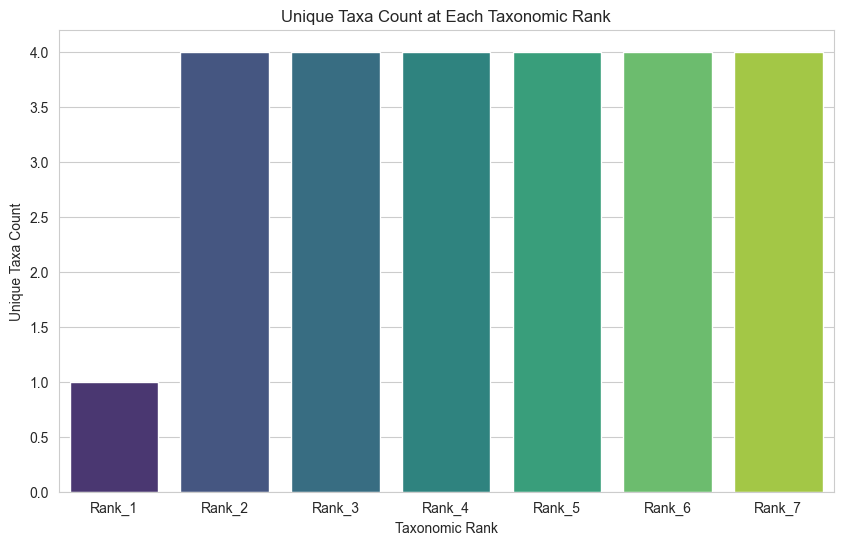

In [95]:
# count unique taxa at each rank
for rank_no in range(1, 8):
    rank_col = "Rank_{}".format(rank_no)
    unique_count = taxonomy[rank_col].n_unique()
    print(f"Unique taxa at {rank_col}: {unique_count}")

# display as a table with xaxis as Rank and y axis as Unique Taxa Count
rank_names = ["Rank_1", "Rank_2", "Rank_3", "Rank_4", "Rank_5", "Rank_6", "Rank_7"]
unique_counts = [taxonomy[rank].n_unique() for rank in rank_names]
plt.figure(figsize=(10,6))
sns.barplot(x=rank_names, y=unique_counts, palette='viridis')
plt.title('Unique Taxa Count at Each Taxonomic Rank')
plt.xlabel('Taxonomic Rank')
plt.ylabel('Unique Taxa Count')
plt.show()

So based on the plot above, there could be `1 * 4^6` unique combinations of ranks. 

# Feature Table EDA

In [96]:
# display head of feature table
print("\nFEATURE TABLE OVERVIEW")
print("=" * 70)
print(f"\nFirst few rows:")
feature_table.head()


FEATURE TABLE OVERVIEW

First few rows:


#OTU ID,Sample_00000,Sample_00001,Sample_00002,Sample_00003,Sample_00004,Sample_00005,Sample_00006,Sample_00007,Sample_00008,Sample_00009,Sample_00010,Sample_00011,Sample_00012,Sample_00013,Sample_00014,Sample_00015,Sample_00016,Sample_00017,Sample_00018,Sample_00019,Sample_00020,Sample_00021,Sample_00022,Sample_00023,Sample_00024,Sample_00025,Sample_00026,Sample_00027,Sample_00028,Sample_00029,Sample_00030,Sample_00031,Sample_00032,Sample_00033,Sample_00034,Sample_00035,…,Sample_00963,Sample_00964,Sample_00965,Sample_00966,Sample_00967,Sample_00968,Sample_00969,Sample_00970,Sample_00971,Sample_00972,Sample_00973,Sample_00974,Sample_00975,Sample_00976,Sample_00977,Sample_00978,Sample_00979,Sample_00980,Sample_00981,Sample_00982,Sample_00983,Sample_00984,Sample_00985,Sample_00986,Sample_00987,Sample_00988,Sample_00989,Sample_00990,Sample_00991,Sample_00992,Sample_00993,Sample_00994,Sample_00995,Sample_00996,Sample_00997,Sample_00998,Sample_00999
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""OTU_0000""",3,5,3,3,6,4,2,8,4,5,1,7,5,4,2,6,6,1,6,9,8,8,10,18,10,6,5,5,7,8,5,3,4,9,2,7,…,10,3,2,4,3,2,6,8,6,7,5,2,7,12,11,2,3,6,3,10,6,3,10,3,4,4,3,3,7,0,5,11,1,5,4,5,4
"""OTU_0001""",12,4,6,9,2,8,5,5,6,14,8,7,3,6,9,6,4,3,7,8,2,3,4,7,4,9,2,2,5,4,5,4,4,3,5,2,…,2,3,11,3,6,2,7,4,7,2,3,4,6,9,4,4,4,5,2,8,2,3,5,9,2,7,5,3,4,2,4,7,6,6,6,5,4
"""OTU_0002""",7,3,9,4,6,4,4,6,4,1,7,1,12,3,3,6,3,0,3,4,10,2,8,5,3,6,8,1,5,9,5,8,5,1,5,2,…,5,9,2,8,4,14,0,5,2,6,4,4,5,4,0,11,6,7,3,9,6,4,3,9,3,17,5,5,3,3,2,7,2,8,3,8,5
"""OTU_0003""",2,3,2,13,6,5,5,7,8,9,2,1,5,8,2,7,4,2,7,2,3,8,2,9,5,7,4,6,7,8,2,8,7,2,4,5,…,2,10,10,4,11,4,1,5,14,5,4,2,10,1,4,3,7,2,2,3,8,3,8,2,2,5,9,1,7,7,2,2,2,4,1,0,2
"""OTU_0004""",6,3,8,6,7,4,2,0,6,1,4,1,5,1,2,6,4,5,3,17,5,9,2,5,2,6,3,4,2,6,5,6,4,7,4,1,…,12,7,10,4,11,6,7,2,8,2,11,9,0,7,4,5,1,2,5,2,8,5,1,2,5,9,11,6,8,8,1,4,6,4,3,3,3


In [97]:
# display size of feature table
print(f"\nFeature table size: {feature_table.shape[0]} rows × {feature_table.shape[1]} columns")


Feature table size: 500 rows × 1001 columns


## Feature Table Structure and Interpretation

The **feature table** is the core dataset representing bacterial abundance across all study participants. This table follows the standard microbiome data structure where:

- **Rows** represent individual **OTUs (Operational Taxonomic Units)** - unique bacterial DNA sequences that cluster together based on genetic similarity (typically 97% sequence similarity threshold)
- **Columns** represent **sample IDs** - individual participants in the study 
- **Values** represent **read counts** - the number of times each bacterial sequence was detected in each participant's microbiome sample through 16S rRNA gene sequencing

**Biological Interpretation:**
- **High counts** (e.g., 500+ reads) indicate that particular bacteria is **abundant** in that person's gut microbiome
- **Low counts** (e.g., 1-10 reads) suggest the bacteria is present but **rare** in that individual
- **Zero counts** mean the bacteria was **not detected** in that sample (below detection threshold)
- **Different patterns across samples** reveal the natural variation in gut microbiome composition between individuals

This abundance matrix allows us to quantify which bacterial communities are dominant or rare in each person's gut, forming the foundation for analyzing how factors like coffee consumption, diet, and demographics influence microbiome composition.

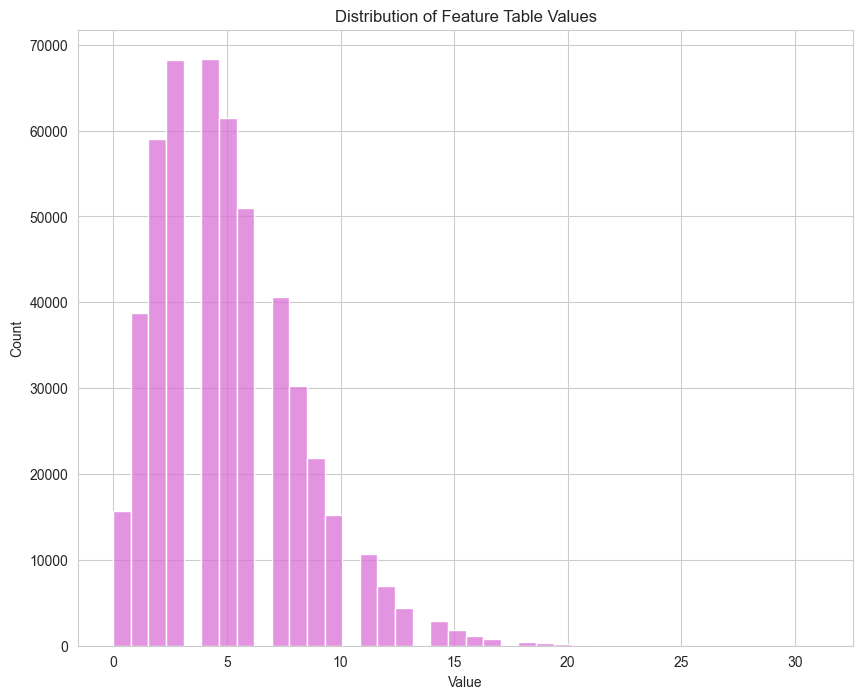

In [98]:
# get numeric columns
numeric_cols = feature_table.select(pl.col(pl.Int64)).columns

# flatten into a list
flattened_values = feature_table.select(numeric_cols).to_numpy().flatten()

# create a histogram
plt.figure(figsize=(10,8))
sns.histplot(x=flattened_values, bins=40, kde=False, color='orchid')
plt.title('Distribution of Feature Table Values')
plt.xlabel('Value') 
plt.ylabel('Count')
plt.show()

In [99]:
# display stats of feature table values
mean_value = np.mean(flattened_values)
std_value = np.std(flattened_values)
min_value = np.min(flattened_values)
max_value = np.max(flattened_values)
median_value = np.median(flattened_values)

print("\nFeature Table Values Statistics:")
print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_value}")
print(f"Minimum: {min_value}")
print(f"Maximum: {max_value}")
print(f"Median: {median_value}")


Feature Table Values Statistics:
Mean: 5.000464
Standard Deviation: 3.1618102069390566
Minimum: 0
Maximum: 31
Median: 4.0
